# CS410/510 HW2: Exploring Word Vectors (20 points)

*   Name: Juhwan Lee
*   PSU ID: 905643246

Please read the README.txt in the same directory as this notebook for important setup information, especially if you are running this Jupyter notebook on your local machine. 


There's also an excellent resource on Python and Numpy [tutorial](https://cs231n.github.io/python-numpy-tutorial/) that might be helpful.


Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


Acknowledgements: This homework has been modeled after Stanford's CS224n.

In [9]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

np.random.seed(0)
random.seed(0)
# ----------------

## Word Vectors

Word Vectors are often used as a fundamental component for many downstream NLP tasks, e.g., text classification, question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses.

The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".


Most word vector models start from the following idea: *You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*



## Loading word vectors

Here, we shall explore the embeddings produced by word2vec and GloVe. 

First, we will explore word2vec. Later, you will replace word2vec with GloVe vectors. More information on pretrained models is here: https://radimrehurek.com/gensim/models/word2vec.html

Run the following cells to load the word2vec vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [10]:
def load_embedding_model():
    """ Load word2vec vectors
        Return:
            wv_from_bin: All embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300") #this downloads the 300-dimensional word2vec vectors trained on Google News corpus, more here: https://radimrehurek.com/gensim/models/word2vec.html
    #wv_from_bin = api.load("glove-twitter-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [11]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple of minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded vocab size 3000000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's visualize the word embeddings. In order to avoid running out of memory, we will work with a sample of 10000 word vectors instead. Run the following cells to:

1. Put 10000 word vectors into a matrix M
2. Run `reduce_to_k_dim` (see Q1) to reduce the vectors from 300-dimensional to 2-dimensional.

In [12]:
def get_matrix_of_vectors(wv_from_bin, required_words=['portland', 'pacific', 'forest', 'ocean', 'city', 'food', 'green', 'weird', 'cool', 'oregon']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3000000 word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

### **Question 1**: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [13]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    svd = TruncatedSVD(n_components = k, n_iter = n_iters, random_state = 123, tol = 0.0)
    M_reduced = svd.fit_transform(M)
    print(M_reduced.shape)
    # ------------------

    print("Done.")
    return M_reduced

In [14]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
(10010, 2)
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. Or, try using Colab.

### **Question 2.1**: Implement `plot_embeddings` [code] (2 points)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [15]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    words_index = [word2ind[word] for word in words]
    print(words_index)
    x_coords = [M_reduced[word_index][0] for word_index in words_index]
    y_coords = [M_reduced[word_index][1] for word_index in words_index]
    
    for i, word in enumerate(words):
        x = x_coords[i]
        y = y_coords[i]
        plt.scatter(x, y, marker = 'x', color = 'red')
        plt.text(x + 0.0003, y + 0.0003, word, fontsize = 9)
    plt.show()
    # ------------------

### **Question 2.2**: word2vec Plot Analysis [written] (3 points)

Run the cell below to plot the 2D word2vec embeddings for `['portland', 'pacific', 'forest', 'ocean', 'city', 'food', 'green', 'weird', 'cool', 'oregon']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have?

[10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009]


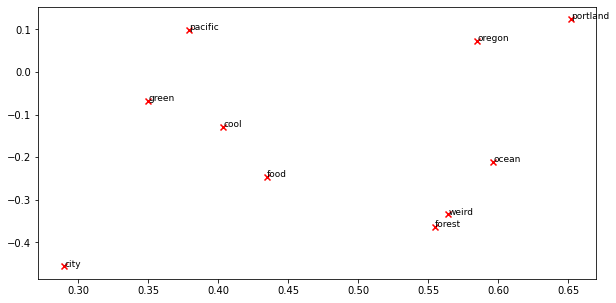

In [16]:
words = ['portland', 'pacific', 'forest', 'ocean', 'city', 'food', 'green', 'weird', 'cool', 'oregon']
plot_embeddings(M_reduced, word2ind, words)

#### <font color="red">Write your answer here.</font>
What clusters together in 2-dimensional embedding space?

- 'oregon', 'portland'

- 'green', 'pacific', 'cool', 'food'

- 'forest', 'weird', 'ocean'

- 'city'

What doesn't cluster together that you think should have?

- 'cool', 'weird'

- 'city', 'portland', 'oregon'

- 'pacific', 'ocean'

- 'green', 'forest'

- 'food'

### **Question 2.3**: GloVe Twitter Plot Analysis [written] (3 points)

In Section **Loading word vectors**, replace word2vec embeddings with GloVe Twitter 200-dimensional embeddings ''glove-twitter-200', and run all the cells again. 

And then run the cell below. What differences do you see in the GloVe embeddings as compared to word2vec embeddings?

[10000, 10001, 10002, 10003, 10004, 10005, 305, 8154, 10006, 10007]


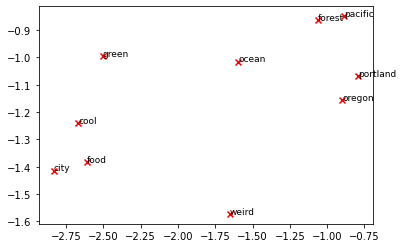

In [8]:
words = ['portland', 'pacific', 'forest', 'ocean', 'city', 'food', 'green', 'weird', 'cool', 'oregon']
plot_embeddings(M_reduced, word2ind, words)

#### <font color="red">Write your answer here.</font>

In GloVe embeddings plot, the clusters are more reasonably formed but it is not perfect as well.
- 'ocean', 'forest', 'pacific'
- 'oregon', 'portland'
- 'city', 'food', 'cool', 'green'
- 'weird'

### **Note: For the following sections, you may choose to continue with GloVe embeddings, or reload the word2vec vectors.**

---




### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can compute the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### **Question 3.1**: Words with Multiple Meanings  [code + written] (2 points)
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [17]:
    # ------------------
    # Write your implementation here.
    print(wv_from_bin.most_similar(['band'])) #did not work
    print(wv_from_bin.most_similar(['close'])) #worked
    # ------------------

[('bands', 0.7978951930999756), ('punk_band', 0.7165399193763733), ('alt_rock_band', 0.7072829604148865), ('indie_rock_band', 0.698492169380188), ('rockers', 0.6857860684394836), ('guitarist', 0.6767148971557617), ('drummer', 0.6747484803199768), ('Band', 0.6676398515701294), ('singer_guitarist', 0.6616649627685547), ('punk_rock_band', 0.66060870885849)]
[('closed', 0.580970823764801), ('closing', 0.547910213470459), ('closest', 0.5217792987823486), ('closer', 0.5146691799163818), ('toclose', 0.5086751580238342), ('Close', 0.4905688762664795), ('open', 0.463651180267334), ('closes', 0.44070184230804443), ('between', 0.4379839301109314), ('nearer', 0.4120941758155823)]


#### <font color="red">Write your answer here.</font>

Word I discovered: close

Top-10 most similar words: [('closed', 0.580970823764801), ('closing', 0.547910213470459), ('closest', 0.5217792987823486), ('closer', 0.5146691799163818), ('toclose', 0.5086751580238342), ('Close', 0.4905688762664795), ('open', 0.463651180267334), ('closes', 0.44070184230804443), ('between', 0.4379839301109314), ('nearer', 0.4120941758155823)]

The word 'band' can mean a small pop music band centered on singers, but it also exists in the form of a verb to affix a band to or tie up with a band. In my opinion, since the word 'band' itself is often used in the form of a noun rather than a verb in the text corpus, the noun form of 'band' is mainly learned, which is the reason why the word 'band' did not work.

### **Question 3.2**: Synonyms & Antonyms  [code + written] (2 points)

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="excited". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [18]:
    # ------------------
    # Write your implementation here.
    w1 = "fun"
    w2 = "amusing"
    w3 = "boring"

    w1_w2_dist = wv_from_bin.distance(w1, w2)
    w1_w3_dist = wv_from_bin.distance(w1, w3)

    print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
    print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))
    # ------------------

Synonyms fun, amusing have cosine distance: 0.5848543047904968
Antonyms fun, boring have cosine distance: 0.5349873304367065


#### <font color="red">Write your answer here.</font>

The above counter-intuitive result is most likely due to the fact that when people write sentences, they typically write 'fun' and 'boring' near each other, whereas 'amusing' may rarely occur in the same neighborhood as 'boring'. As a result, the cosine distance between 'fun' and 'boring' is less than the cosign distance between 'fun' and 'amusing'.

### **Question 3.3**: Analogies with Word Vectors [written] (1 point)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [19]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]


Let $m$, $k$, $w$, and $x$ denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using **only** vectors $m$, $k$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?

#### <font color="red">Write your answer here.</font>

𝑘 - 𝑚 + 𝑤

### **Question 3.4**: Finding Analogies [code + written]  (1 point)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [20]:
    # ------------------
    # Write your implementation here.
    # white : black :: up : down
    pprint.pprint(wv_from_bin.most_similar(positive=['up', 'black'], negative=['white']))
    # ------------------

[('down', 0.5569672584533691),
 ('out', 0.4760546088218689),
 ('off', 0.46158626675605774),
 ('in.', 0.43648242950439453),
 ('ups', 0.418761670589447),
 ('up.The', 0.4140004515647888),
 ('back', 0.40225571393966675),
 ('upthe', 0.39737647771835327),
 ('aside', 0.3968466520309448),
 ('slack_Drevna', 0.3806280791759491)]


#### <font color="red">Write your answer here.</font>

white : black :: up : down

### **Question 3.5**: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [21]:
    # ------------------
    # Write your implementation here.
    # intended analogy -- portland : oregon :: seattle : washington
    pprint.pprint(wv_from_bin.most_similar(positive=['seattle', 'oregon'], negative=['portland']))
    # ------------------

[('wisconsin', 0.5179064273834229),
 ('south_carolina', 0.5077054500579834),
 ('arkansas', 0.4946818947792053),
 ('michigan', 0.4880446791648865),
 ('pennsylvania', 0.4838385581970215),
 ('florida', 0.48243725299835205),
 ('alabama', 0.4802580177783966),
 ('boston', 0.4778832793235779),
 ('california', 0.4766072928905487),
 ('denver', 0.47576406598091125)]


#### <font color="red">Write your answer here.</font>

Intended analogy -- portland : oregon :: seattle : washington

The incorrect value of b: wisconsin

### **Question 3.6**: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [22]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('workers', 0.6582455635070801),
 ('employee', 0.5805293321609497),
 ('nurse', 0.5249921679496765),
 ('receptionist', 0.5142490267753601),
 ('migrant_worker', 0.5001609325408936),
 ('Worker', 0.4979269802570343),
 ('housewife', 0.48609834909439087),
 ('registered_nurse', 0.4846190810203552),
 ('laborer', 0.48437267541885376),
 ('coworker', 0.48212406039237976)]

[('workers', 0.5590360164642334),
 ('laborer', 0.54481041431427),
 ('foreman', 0.5192232131958008),
 ('Worker', 0.5161596536636353),
 ('employee', 0.5094279050827026),
 ('electrician', 0.49481213092803955),
 ('janitor', 0.48718899488449097),
 ('bricklayer', 0.4825313091278076),
 ('carpenter', 0.47498998045921326),
 ('workman', 0.4642517566680908)]


#### <font color="red">Write your answer here.</font>

(a) which terms are most similar to "woman" and "worker" and most dissimilar to "man"?

nurse, receptionist, migrant_worker, housewife, registered_nurse

(b) which terms are most similar to "man" and "worker" and most dissimilar to "woman"?

foreman, electrician, janitor, bricklayer, carpenter, workman

(c) Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

Female associated words are occupations that were mainly performed by women in the past and occupations that require subtlety rather than strength, and male associated words are occupations that were mainly performed by men in the past and occupations that require a lot of strength. But now, this trend has disappeared, and there are many male nurses and many female carpenters. If the prediction results continue to be biased, gender and religious conflicts will intensify.

### **Question 3.7**: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [23]:
    # ------------------
    # Write your implementation here.
    pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'sport'], negative=['man']))
    print()
    pprint.pprint(wv_from_bin.most_similar(positive=['man', 'sport'], negative=['woman']))
    # ------------------

[('sports', 0.5522487163543701),
 ('Snooki_wannabes', 0.5343652963638306),
 ('alpine_ski_racing', 0.4878804087638855),
 ('equestrianism', 0.4868336021900177),
 ('Modern_pentathlon', 0.4789583683013916),
 ('sportswoman', 0.4750139117240906),
 ('marathoning', 0.47279438376426697),
 ('painkillers_throat_lozenges', 0.47224149107933044),
 ('Rhythmic_gymnastics', 0.46581119298934937),
 ('athletics', 0.4654000997543335)]

[('sports', 0.5889081358909607),
 ('sportsman', 0.534942090511322),
 ('sporting', 0.5343065857887268),
 ('football', 0.505908727645874),
 ('racing', 0.4945325255393982),
 ('Pole_vaulting', 0.4768719971179962),
 ('racings', 0.47185537219047546),
 ('boxing', 0.47016268968582153),
 ('Ultimate_frisbee', 0.4700000286102295),
 ('snowboarding_skateboarding', 0.4662424921989441)]


#### <font color="red">Write your answer here.</font>

I discovered that there is a bias between man and woman in sport. Man associated words are football, racing, and boxing and woman associated words are alpine ski, marathoning, and rythmic gymnastics. There are woman football, woman boxing, and woman racing, and there are man alpine ski, man marathon, and man rythmic gymnastics. Gender should not be the benchmark in classifying sports.

### **Question 3.8**: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

#### <font color="red">Write your answer here.</font>

Because the dataset we use has bias, it outputs bias because it is trained based on that dataset. The good news is that it is possible to detect these biases. Assume we want to find out if a word embedding for the concept 'c' has a gender bias. We can subtract the cosine distance between 'c' and 'Man' from the cosine distance between 'c' and 'Woman.' A non-zero result indicates bias in one direction or the other, and the magnitude of the result indicates how much bias there is.

# <font color="blue"> Submission Instructions</font>

When you are satified with your results, you can submit this assignment by doing the following:

1. Click the Save button at the top of the Jupyter Notebook.

2. Add your name and PSU ID # at the top.

3. **For Colab**: 

(i) Select *Edit > Clear All Outputs*.

(ii) Click *Runtime > Restart and Run All*.


(iii) Click *File > Print* and print to PDF. Name the file hw#_[odin_userid].pdf (for example Homework 1 for John Doe might be hw1_jdoe.pdf)
   
3. **For Jupyter running on local machine**:

(i) Select *Cell -> All Output -> Clear*. This will clear all the outputs from all cells (but will keep the content of all cells).

(ii) Select *Cell -> Run All*. This will run all the cells in order, and will take several minutes.

(iii) Once you've rerun everything, select *File -> Download as -> PDF via LaTeX*.


4. Look at the PDF file and make sure all your solutions are there, displayed correctly.

5. Also download your .ipynb.

5. Submit both the PDF file and the Jupyter notebook (.ipynb) on D2L under *Activities > Assignment* under the appropriate assignment.